In [1]:
import $file.scripts.importer

importer.loadProjectDependencies

import $file.$               



In [2]:
import scala.collection.JavaConverters._
import scala.collection.JavaConversions._
import edu.stanford.math.plex4._
import edu.stanford.math.plex4.api._
import edu.stanford.math.plex4.visualization._
import edu.stanford.math.plex4.homology.barcodes._

import breeze.numerics._
import breeze.linalg._
import breeze.math._
import breeze.stats.{mean, stddev}
import breeze.util.JavaArrayOps

import tda.persistence.Analysis._
import tda.persistence.Math

implicit def mapEntryAsTuple[T,S](me: java.util.Map.Entry[T,S]): (T,S) = {
  (me.getKey(), me.getValue)
}

def drawBarcodes(images: Seq[java.awt.image.BufferedImage]) = {
  images foreach publish.png 
}


import scala.collection.JavaConverters._

import scala.collection.JavaConversions._

import edu.stanford.math.plex4._

import edu.stanford.math.plex4.api._

import edu.stanford.math.plex4.visualization._

import edu.stanford.math.plex4.homology.barcodes._


import breeze.numerics._

import breeze.linalg._

import breeze.math._

import breeze.stats.{mean, stddev}

import breeze.util.JavaArrayOps


import tda.persistence.Analysis._

import tda.persistence.Math


defined function mapEntryAsTuple
defined function drawBarcodes

In [3]:
lazy val stream = Plex4.createExplicitSimplexStream()

stream.addVertex(0)
stream.addVertex(1)
stream.addVertex(2)
stream.addElement(Array(0, 1))
stream.addElement(Array(0, 2))
stream.addElement(Array(1,2))
stream.finalizeStream()

stream.getSize

stream: streams.impl.ExplicitSimplexStream = <lazy>
res2_8: Int = 6

In [4]:
lazy val persistence = Plex4.getModularSimplicialAlgorithm(3, 2)
lazy val circleIntervals = persistence.computeIndexIntervals(stream)

persistence: homology.interfaces.AbstractPersistenceAlgorithm[homology.chain_basis.Simplex] = <lazy>
circleIntervals: BarcodeCollection[Integer] = <lazy>

## 9 - sphere 

In [5]:
lazy val dimension = 9
lazy val stream = Plex4.createExplicitSimplexStream()
stream.addElement(0 to (dimension + 1) toArray)
stream.ensureAllFaces()
stream.removeElementIfPresent(0 to (dimension + 1) toArray)
stream.finalizeStream()

lazy val persistence9 = Plex4.getModularSimplicialAlgorithm(dimension + 1, 2)

dimension: Int = <lazy>
stream: streams.impl.ExplicitSimplexStream = <lazy>
res4_4: Boolean = true
persistence9: homology.interfaces.AbstractPersistenceAlgorithm[homology.chain_basis.Simplex] = <lazy>

In [6]:
lazy val intervals9 = persistence.computeIntervals(stream)

intervals9: BarcodeCollection[java.lang.Double] = <lazy>

# House

### Explicit stream

In [7]:
lazy val houseStream = Plex4.createExplicitSimplexStream();
houseStream.addVertex(1, 0);
houseStream.addVertex(2, 0);
houseStream.addVertex(3, 0);
houseStream.addVertex(4, 0);
houseStream.addVertex(5, 1);
houseStream.addElement(Array(1, 2), 0);
houseStream.addElement(Array(2,3), 0);
houseStream.addElement(Array(3, 4), 0);
houseStream.addElement(Array(4, 1), 0);
houseStream.addElement(Array(3, 5), 2);
houseStream.addElement(Array(4, 5), 3);
houseStream.addElement(Array(3, 4, 5), 7);
houseStream.finalizeStream()

houseStream: streams.impl.ExplicitSimplexStream = <lazy>

In [8]:
lazy val intervals = persistence.computeIntervals(houseStream)
lazy val actualIntervals = intervals.getIntervalIterator.asScala.map(_.getValue).toList
actualIntervals.length

intervals: BarcodeCollection[java.lang.Double] = <lazy>
actualIntervals: List[java.util.List[Interval[java.lang.Double]]] = <lazy>
res7_2: Int = 2

In [9]:
lazy val intervalsDim0 = BarcodeUtility.getEndpoints(intervals, 1, false)

intervalsDim0: Array[Array[Double]] = <lazy>

### Vietoris-Rips from point cloud

In [10]:
lazy val pointCloud = examples.PointCloudExamples.getHouseExample()
lazy val houseMetricSpace= new metric.impl.EuclideanMetricSpace(pointCloud)

lazy val (maxDimension, maxFiltrationValue, numDivisions)= (3, 4.0, 100)

lazy val vietorisRipsStream = api.Plex4.createVietorisRipsStream(
  houseMetricSpace,
  maxDimension,
  maxFiltrationValue,
  numDivisions)

lazy val houseIntervals = persistence.computeIntervals(vietorisRipsStream)

lazy val houseImgs = barcodeImages(vietorisRipsStream, maxDimension, maxFiltrationValue, persistence)

pointCloud: Array[Array[Double]] = <lazy>
houseMetricSpace: metric.impl.EuclideanMetricSpace = <lazy>
maxDimension: Int = <lazy>
maxFiltrationValue: Double = <lazy>
numDivisions: Int = <lazy>
vietorisRipsStream: streams.impl.VietorisRipsStream[Array[Double]] = <lazy>
houseIntervals: BarcodeCollection[java.lang.Double] = <lazy>
houseImgs: List[java.awt.image.BufferedImage] = <lazy>

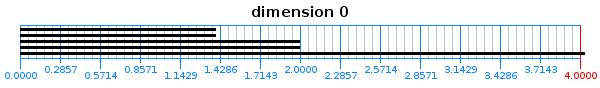

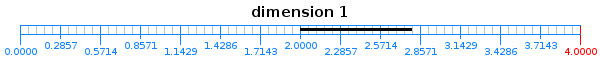

In [20]:
drawBarcodes(houseImgs)

## Torus homology 

In [12]:
lazy val torusData = csvread(importer.loadData("pointsTorusGrid.csv"))

lazy val torusDataArray = JavaArrayOps.dmDToArray2(torusData)

lazy val (maxDimension, maxFiltrationValue, numDivisions) = (3, 0.9, 100)

lazy val torusStream = Plex4.createVietorisRipsStream(torusDataArray, maxDimension, maxFiltrationValue, numDivisions)

lazy val torusImages = barcodeImages(torusStream, maxDimension, maxFiltrationValue, persistence)

torusData: DenseMatrix[Double] = <lazy>
torusDataArray: Array[Array[Double]] = <lazy>
maxDimension: Int = <lazy>
maxFiltrationValue: Double = <lazy>
numDivisions: Int = <lazy>
torusStream: streams.impl.VietorisRipsStream[Array[Double]] = <lazy>
torusImages: List[java.awt.image.BufferedImage] = <lazy>

In [19]:
println(Seq(
  "TorusStream for",
  s"maxFiltrationValue = ${maxFiltrationValue}",
  s"has ${torusStream.getSize()} simplices").mkString("\n"))

TorusStream for
maxFiltrationValue = 0.9
has 82479 simplices


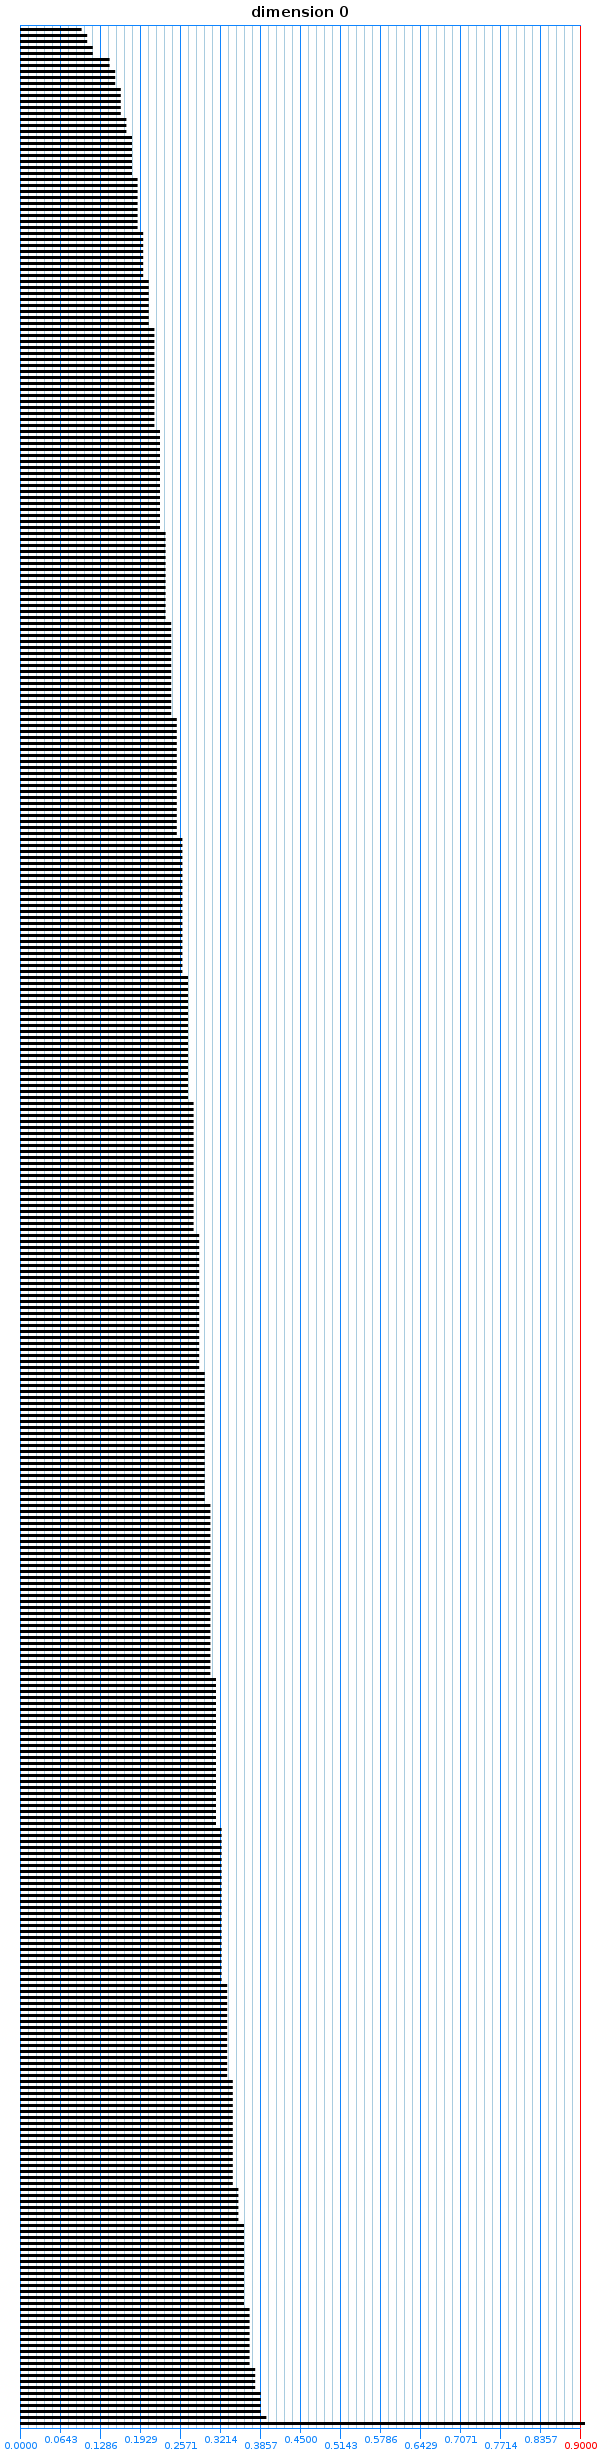

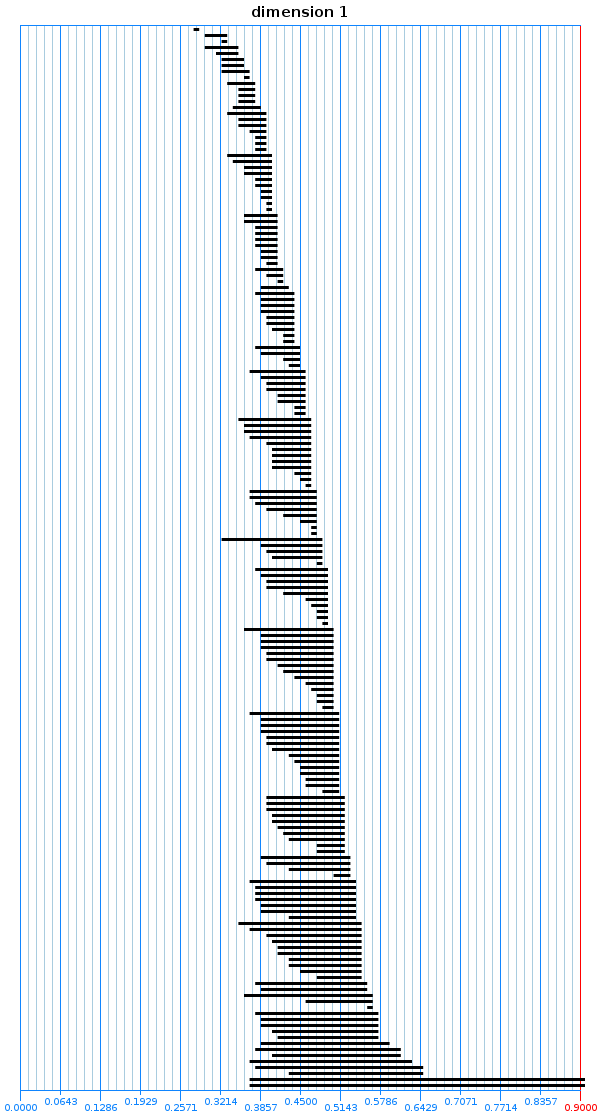

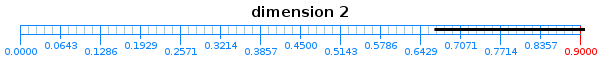

In [14]:
drawBarcodes(torusImages)

## Torus homology with witnesses

In [15]:
lazy val noLandmarkPoints = 50 
lazy val witnessMaxFiltrationValue = 2* maxFiltrationValue

noLandmarkPoints: Int = <lazy>
witnessMaxFiltrationValue: Double = <lazy>

In [16]:
lazy val landmarkIndices = Plex4
  .createMaxMinSelector(torusDataArray, noLandmarkPoints)
  .getLandmarkPoints()

lazy val torusWitnesses= landmarkIndices.map(torusDataArray(_))

lazy val torusWitnessStream = Plex4.createVietorisRipsStream(torusWitnesses, maxDimension, witnessMaxFiltrationValue, numDivisions)

lazy val torusWitnessImages = barcodeImages(torusWitnessStream, maxDimension, witnessMaxFiltrationValue, persistence)

landmarkIndices: Array[Int] = <lazy>
torusWitnesses: Array[Array[Double]] = <lazy>
torusWitnessStream: streams.impl.VietorisRipsStream[Array[Double]] = <lazy>
torusWitnessImages: List[java.awt.image.BufferedImage] = <lazy>

In [17]:
println(Seq(
  s"WitnessTorusStream for ${torusWitnesses.size} witnesses",
  s"witnessMaxFiltrationValue = ${witnessMaxFiltrationValue} = ${witnessMaxFiltrationValue / maxFiltrationValue} * maxFiltrationValue",
  s"has ${torusWitnessStream.getSize()} simplices",
  s"(${torusStream.getSize() / torusWitnessStream.getSize()}x less than original stream)").mkString("\n"))

WitnessTorusStream for 50 witnesses
witnessMaxFiltrationValue = 1.8 = 2.0 * maxFiltrationValue
has 2359 simplices
(34x less than original stream)


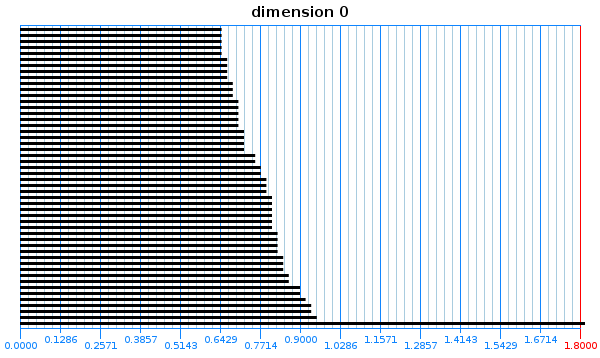

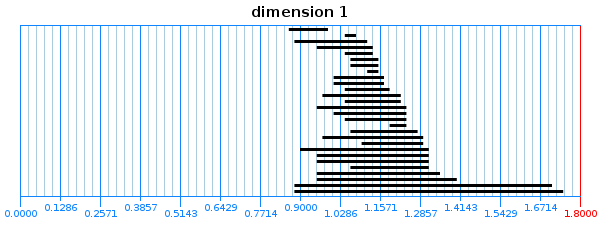

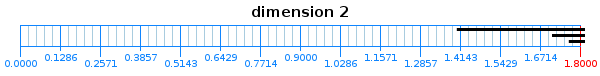

In [18]:
drawBarcodes(torusWitnessImages)